# Finding Adjacent Frequency Signals from Different On-Sky Targets

Noah Stiegler

7/1/24

## Setup

In [22]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy.coordinates import Angle
from astropy.table import Table
from astropy.time import Time
import seaborn as sns
from scipy.sparse import csr_array
from scipy.sparse import lil_array


In [23]:
# Read in the data

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1":
    full_dataset_path = "/datax/scratch/nstieg/25GHz_higher.pkl"
    coherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_coherent.pkl"
    incoherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_incoherent.pkl"
else:
    raise Exception("Data path not known")

# Read in data
coherent = pd.read_pickle(coherent_dataset_path)
# incoherent = pd.read_pickle(incoherent_dataset_path)
# df = pd.read_pickle(full_dataset_path)

In [24]:
coherent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2984740 entries, 0 to 31107169
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   signal_frequency         float64       
 2   signal_drift_rate        float64       
 3   signal_snr               float64       
 4   signal_beam              int64         
 5   signal_power             float64       
 6   signal_incoherent_power  float64       
 7   signal_num_timesteps     int64         
 8   tstart                   float64       
 9   tstart_h                 datetime64[ns]
 10  ra_hours                 float64       
 11  dec_degrees              float64       
 12  source_name              object        
dtypes: datetime64[ns](1), float64(8), int64(3), object(1)
memory usage: 318.8+ MB


## Find frequency "distances" between hits

### Explanation

One idea we have to find RFI is to see if the same frequency is found as a hit 
on two different parts of the sky. This would be easy if we had multiple beams
per FOV, but because this is a higher frequency observation, we don't (because
the FOV gets smaller at high frequencies and at these frequencies we don't have 
enough target density in order to get multiple targest to beamform on in an FOV)
So instead, we're going to check to see if the same exact frequency hit is found 
from different fov pointings. This is likely RFI because it's unlikely that
two different extraterrestrials are transmitting at exactly the same frequency
(within our frequency resolution of +/- 2-8 hz) and that the relative motions
of their transmitters doppler shift the signals to exactly the same frequency as
well. So if we point in one direction and see something, and point in a different
direction and see the same thing, then it's likely coming from the Earth. This is
kind of similar to what the single-dish antennas do with the ABACAD observation
pattern, except we aren't controlling the pointing so we don't know if we're going
back to the same source multiple times.

To do this computation, we're going to compute the frequency "distance" between all hits
defined as (f1 - f2). If they're the same frequency this "distance" will be small (on the
order of our frequency resolution) so we can then find the hits that are from the same
freuqencies on different parts of the sky

So we want to end up with an array which contains the difference in frequencies between all pairs of hits
To do this, I want to end up with an array which looks like

In [25]:

# a0 - b0, a0 - b1, a0 - b2, ...
# a1 - b0, a1 - b1, a1 - b2, ...
# a2 - b0, a2 - b1, a2 - b2, ...

where the vectors *a* and *b* contain the frequencies of all the hits (to compare to each other) 
Making this array is equivalent to subtracting two matrices A and B where


In [26]:
#     a0 a0 a0 ...
# A = a1 a1 a1 ...
#     a2 a2 a2 ...

#     b0 b1 b2 ...
# B = b0 b1 b2 ...
#     b0 b1 b2 ...

In [27]:
# Simple example of what I'm trying to do
a = np.array([100, 200, 300]).reshape(1, 3)
b = np.array([1, 2, 3]).reshape(1, 3)
print(a + b.T)

[[101 201 301]
 [102 202 302]
 [103 203 303]]


which we can do via numpy broadcasting
However, we can't just do this for the full coherent data, because that would be 
2.9M ^ 2 (elements in array) * 8 (bytes per element) ~= 70 Terabytes of memory :|
Even noting that (with all coherent data), a and b are the same so we can just
take the upper triangular part of the matrix, the servers don't have 35Tb of memory

So first, I am going to figure out which observational blocks are overlapping in frequency,
and then compute the distances between those points, then finally threshold distances to 
find which ones are close enough to each other to basically be the same
So I'm going to create a boolean array where C[source_1, source_2] is true if they
are overlapping in observational frequency
This array should be symmetric, with True on the diagonal, but I don't really care to 
optimize it because it'll be so small. It'll look like:


In [28]:
# Source: 1   2   3   ...   n
# 1       T   T   F
# 2       T   T   F
# 3       F   F   T
# ...
# n

### Investigate a 'rolling average' and using a sparse matrix


#### Explanation

So another idea I had to do this comparison was to sort all the data by frequency so I don't have to compare every hit to every other hit that could possibly be within a certain distance of it. If I deem that a point is close enough in frequency to another point to compare, I can add that distance into a sparse matrix. 


Essentially, I'm constructing a moving window around the point I'm investigating that holds every point +/- window_width from it in frequency. I then compute the distance from the point I care about to every other point in the window.

In [29]:
# Example)
# Frequency   11 15 17 19 115 138  ----> sorted increasingly
# hit index   1  0  3  4  2   5  ... not necessarily sorted

# Sparse matrix (indexed by hit index)
# We know it will be upper triangular (because dist(a, b) == -dist(b, a) and dist(a, a) == 0)
# For example, the distance beween point 0 and point 3 is (15 - 17) = -2
#   | 0 1 2 3 4 5
# --+-----------------
# 0 | -     -2
# 1 |   -
# 2 |     -
# 3 |       -
# 4 |         -
# 5 |           -

Because I'll start with the lowest frequency and move up, I only have to look at points which are higher frequency than the one I'm currently looking at (because I will have already compared any points behind the one I'm currently looking at if they're within the window to each other). Here's an explanation of the algorithm

In [30]:
# Example)
# Frequency   11 15 17 19 115 138  ----> sorted increasingly
# hit index   1  0  3  4  2   5  ... not necessarily sorted
# frequency_window_width = 7 Hz
#
# First hit is 11, so the window will contain nothing behind it (first element)
# and all elements within 7 frequency ahead of it (up to 17)
#
#          Window when 1st comparisons happen
# curr_index: (0)                    # This is the index in the sorted list of the frequency we're currently comparing
# Frequency   11 15 17 19 115 138  ----->
# hit index   1  0  3  4  2   5   ...
# window      |--(2)--|             # Window is represented by how many hits ahead of the current hit we want to compare
#
# So we compute the distance between the hit with index 1 to those with
# indices 0 and 3 and store those in the sparse matrix. Then it's time to
# move the window.
# But how is the window represented? Well we don't need to compare a hit to itself,
# so it's the number of elements in the list ahead of the current element.
# So for the first window, it would be represented as 2, because we want to
# compare hit index 1 to the two hits ahead of it
#
# So now that we've computed the distance between the hit with index 1 and
# all hits within 7 Hz of it, we know we never have to compute a distance
# involving this hit again. In fact, this will be true for future hits.
# We never have to compute a distance to a hit lower than it in frequency
# because if they were within the right window distance of each other, they
# already would have been computed. This is why we only need a 'forward window'
# even though we compare hits which are within +/- the window size in frequency
#
# So it's time to move. We move curr_index to 1 (consider next hit).
# Then we have to move the window. We know everything that was in the window
# before we is going to be within the window size of this new point (excluding the
# new point) so the window size shrinks from 2 to 1 (if it was 0, it would stay).
# Then we have to see if we want to add a new point to the window, so we look at
# the next point after the current window, and if it's within the window, we 
# increase the window size by 1 (to include it) and check if the next point
# is also within the window. Once we reach a point which is too far outside, we can stop.
# Also check to make sure the window size isn't at the end of the array.
#
#     Window after shrinking by 1 element and before expanding
# curr_index:    (1)                    
# Frequency   11 15 17 19 115 138  ----->
# hit index   1  0  3  4  2   5   ...
# window         |(1)-|             
#
#     Window after expanding by 1 element (19 is within 7 of 15)
# curr_index:    (1)                    
# Frequency   11 15 17 19 115 138  ----->
# hit index   1  0  3  4  2   5   ...
# window         |--(2)--|             
#
#     Window when 2nd round of comparisons happen (115 is too far, so it stops)
# curr_index:    (1)                    
# Frequency   11 15 17 19 115 138  ----->
# hit index   1  0  3  4  2   5   ...
# window         |--(2)--|             

#### Code

##### Get the data

In [31]:
# Just try this out with data from the first timestamp to see if it works
first_time = coherent["tstart"][0]
test_data = coherent[coherent["tstart"] == first_time]
test_data.reset_index(drop=True, inplace=True) # Important so the indices are consecutive

# Cut down the data to just the frequency
fs = test_data["signal_frequency"] # fs is frequencies

##### Check what the traditional distance method yields

In [32]:
a = fs.to_numpy().reshape(1, -1)
b = fs.to_numpy().reshape(-1, 1)
true_distances = abs(a - b)
true_distances[np.tril_indices(len(fs), k=0)] = np.nan
print(true_distances.shape)
print(true_distances[:5, :5])
num_distances = len(fs)**2 - np.isnan(true_distances).sum()
print(f"{num_distances} points are not NaN of {len(fs)**2} ({round(num_distances / (len(fs)**2), 4)}%)")

(1800, 1800)
[[       nan 0.24833679 0.21554947 0.4553051  0.39719772]
 [       nan        nan 0.03278732 0.70364189 0.64553452]
 [       nan        nan        nan 0.67085457 0.61274719]
 [       nan        nan        nan        nan 0.05810738]
 [       nan        nan        nan        nan        nan]]
1619100 points are not NaN of 3240000 (0.4997%)


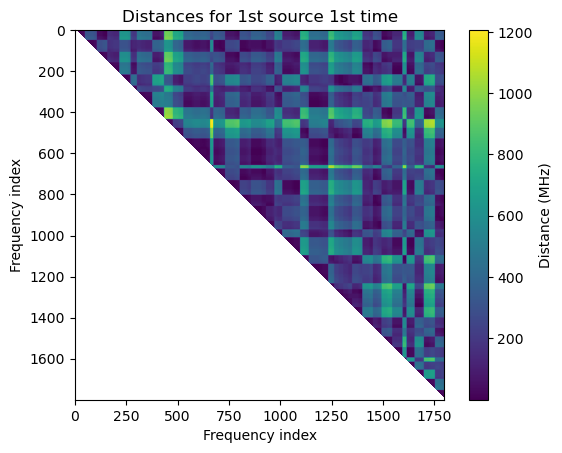

In [33]:
# Show the distances
plt.imshow(true_distances)
cbar = plt.colorbar(label="Distance (MHz)")
plt.xlabel("Frequency index")
plt.ylabel("Frequency index")
plt.title("Distances for 1st source 1st time")
plt.show()

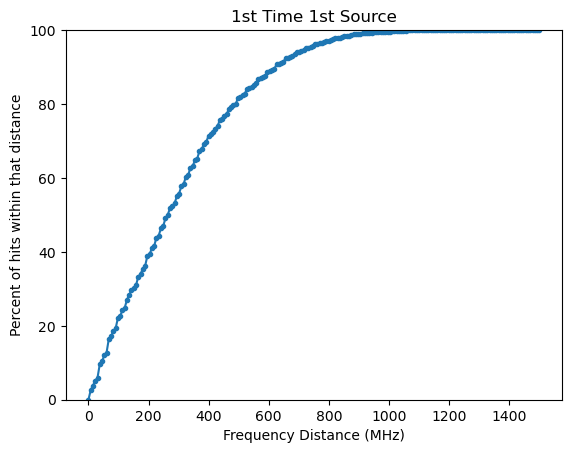

In [34]:
# Look at percent over a certain distance
xaxis = np.linspace(0, 1.5e9, 200) * 1e-6
yaxis = [((true_distances <= x).sum() / num_distances) * 100 for x in xaxis]
plt.plot(xaxis, yaxis, marker='.')
plt.ylim([0, 100])
plt.xlabel("Frequency Distance (MHz)")
plt.ylabel("Percent of hits within that distance")
plt.title("1st Time 1st Source")
plt.show()

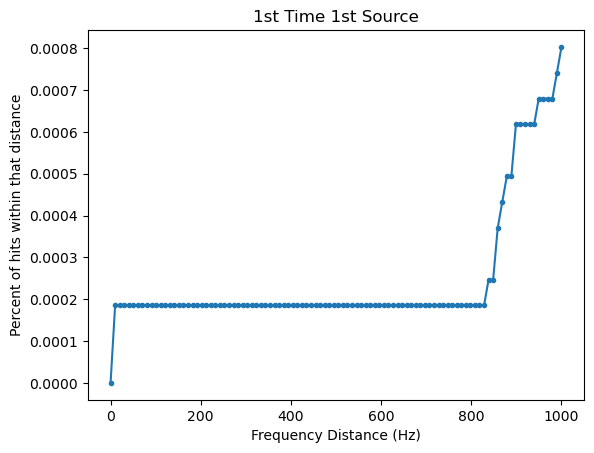

In [35]:
# Same but for smaller distances
xaxis = np.linspace(0, 1000, 100)
yaxis = [((true_distances <= x * 1e-6 ).sum() / num_distances) * 100 for x in xaxis]
plt.plot(xaxis, yaxis, marker='.')
# plt.ylim([0, 100])
plt.xlabel("Frequency Distance (Hz)")
plt.ylabel("Percent of hits within that distance")
plt.title("1st Time 1st Source")
plt.show()

In [36]:
# Check what the indices of the ones within 100hz are
truly_within_100hz = (true_distances <= 100e-6)
print(f"{truly_within_100hz.sum()} ({round(truly_within_100hz.sum() / num_distances * 100, 3)}%) are within 100hz")
print(truly_within_100hz.nonzero())

3 (0.0%) are within 100hz
(array([ 84,  86, 576]), array([703, 706, 638]))


##### Try the new algorithm

In [37]:
# Sort the data by frequency
sfs = fs.sort_values() # sfs is sorted frequencies
# now sfs.iloc[0] gives the lowest frequency
# and sfs.loc[0] gives the frequency with index 0

# Make sure to keep track of the original indices
original_indices = sfs.index # Maps index in sfs to index in fs
# So the element at sfs[0] has index in fs of original_indices[0]. 
# In other words sfs[0] == fs[original_indices[0]]

Maybe turn into function later

In [38]:
# Find adjacent points (like algorithm described above)
# data: pandas series 
# window_width: width of window to find adjacency in same units as data (ie MHz and MHz)
# Returns:
# (distances, mask) tuple
# distances is a scipy sparse lil_array of float distances between adjacent points
# mask is a scipy sparse lil_array of booleans indicating whether 
# def find_adjacent_distances(data, window_width)

Code

In [39]:
# Define parameters
window_width_hz = 100 # Width of the frequency window

# Build empty distances array
# Arrays will be upper triangular, so only store information in the upper half (excluding diagonals)
# So the row is the smaller index. To compare hits i and j for i < j index at [i, j] 
# Use sparse lil_array to build a sparse array item by item quickly
# It also has efficient row slicing which is what we care about
num_hits = len(fs)
# Stores whether a value was stored or not (otherwise 0 is ambiguous in distances). Initializes to all False
mask = lil_array((num_hits, num_hits), dtype=bool) 
# Stores the value if it was stored, or 0 if not
distances = lil_array((num_hits, num_hits), dtype=np.float32) 

# Function to find the window size for a given state
# Pass in sorted frequencies, width of window in frequency, 
# current index in sorted array, and the current window size
def find_window_size(sfs, window_width, curr_idx, window_size):
    # Setup constraints
    curr_point = sfs.iloc[curr_idx] # Frequency we're comparing to
    max_allowable_idx = num_hits - 1 # Don't index off the end of the array

    # Test each new element to see if we should add it to the window
    test_window_size = window_size + 1
    new_point_in_window_idx = curr_idx + test_window_size
    while (new_point_in_window_idx <= max_allowable_idx):
        # Get the value of the next frequency adjacent to window without indexing off the array
        new_point_in_window = sfs.iloc[new_point_in_window_idx]
        
        # Check if this point is within the window width
        if (abs(new_point_in_window - curr_point) <= window_width):
            # Window should grow
            window_size = test_window_size
            test_window_size = window_size + 1
            new_point_in_window_idx = curr_idx + test_window_size
        else:
            # Window shouldn't grow
            return window_size

    # Window includes the end of the array already
    return window_size 

# Setup for algorithm
window_width = window_width_hz / 1e6 # in MHz
window_size = 0 # Window size as number of indices in sorted list

# Run Algorithm:
# curr_idx is an index in the sorted list
for curr_idx in range(num_hits):
    # Calculate the window size
    window_size = find_window_size(sfs, window_width, curr_idx, window_size)
    
    if window_size > 0:
        # Get the index of the hit
        unsorted_curr_idx = original_indices[curr_idx]

        # Get the frequency of the current hit
        curr_freq = sfs.iloc[curr_idx]

        # Calculate and store distance to each item in the window
        for i in range(window_size):
            i = (curr_idx + 1) + i # Start counting from the frequency after the current frequency
            
            # Set 'adjacent' to true in the mask
            unsorted_i = original_indices[i]
            mask[unsorted_curr_idx, unsorted_i] = True

            # Calculate and store distance
            distances[unsorted_curr_idx, unsorted_i] = abs(sfs.iloc[i] - curr_freq)
        
        # Shrink the window size since we move up one index
        window_size -= 1

In [40]:
# Look at the ([rows], [columns]) where elements are
print(mask.nonzero())
print(distances.nonzero())


(array([ 84,  86, 638], dtype=int32), array([703, 706, 576], dtype=int32))
(array([ 84,  86, 638], dtype=int32), array([703, 706, 576], dtype=int32))


In [41]:
# Check against the first method
print(truly_within_100hz.nonzero())

(array([ 84,  86, 576]), array([703, 706, 638]))


In [42]:
distances[distances.nonzero()].toarray()

array([[8.3308987e-07, 8.3308987e-07, 8.3308987e-07]], dtype=float32)

In [43]:
# mess around with sparse arrays to make sure I can threshold them and figure out which elements are
# adjacent to which other elements
m = np.array([[True, True],
             [True, False],
             [False, True],
             [False, False]])
d = np.array([[0, 1],
             [2, 3],
             [4, 5],
             [6, 7]])
mask = lil_array(m , dtype=bool)
distances = lil_array(d, dtype=float)
thresh = distances > 3 
care = mask.multiply(thresh)
print(care.toarray())
print(type(care))
print(np.sum(care))

[[False False]
 [False False]
 [False  True]
 [False False]]
<class 'scipy.sparse._arrays.csr_array'>
1
